In [13]:
import os
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
os.environ["NUMEXPR_NUM_THREADS"] = "20"
from importlib import reload
import yee_uchie_QM_pml_class
reload(yee_uchie_QM_pml_class)
from yee_uchie_QM_pml_class import Source, Recorder, QM_UCHIE_params, Yee_UCHIE
import QM_update as QM
import numpy as np
import scipy.constants as ct
import time
from scipy.special import hankel2
import matplotlib.pyplot as plt




99988096.6049447

In [2]:
eps0 = ct.epsilon_0
mu0 = ct.mu_0
hbar = ct.hbar #J⋅s
m = ct.electron_mass*0.15
q = -ct.elementary_charge
c0 = ct.speed_of_light 


Z0 = np.sqrt(mu0/eps0)


In [3]:
Nx = 501
Ny = 501
Nt = 500

dx = 0.25e-10 # m
dy = 0.25e-10 # ms
courant = 0.9 # !Courant number, for stability this should be smaller than 1
dt = courant * 1/(np.sqrt(1/dx**2 + 1/dy**2)*ct.c)

Ly = 3/5*Ny*dy
n = 5 #@ numbers of Subgridding in one grid
N_sub = 15 #@ How much grid you want to take to subgrid

x_sub1 = Nx//2*dx #@ The locationwhere the first subgridding should happen
x_sub2 = 2*Nx//3*dx #@ The locationwhere the first subgridding should happen

QMxpos1 = n*N_sub//2
QMxpos2 = n*N_sub//2


NyQM = int(2*Ny/5)

#create the source
xs = 2/5*Nx*dx
ys = Ny/2*dy
tc = dt*Nt/4
sigma = tc/10
J0 = 1e2/dx/dy
source = Source(xs, ys, J0, tc, sigma)

N = 10e7 #particles/m2
#NyQM = int(2*Ny/3)
order = 'fourth'
omega = 50e14 #[rad/s]
alpha = 0


pml_nl = 20
pml_m = 4


In [4]:
potential = QM.Potential(m,omega, NyQM, dy)
#potential.V()

QMscheme1 = QM.QM(order,NyQM,dy, dt, hbar, m, q, alpha, potential, omega, N)
QMscheme2 = QM.QM(order,NyQM,dy, dt, hbar, m, q, alpha, potential, omega, N)

#recorders in YEE region
recorder1 = Recorder(0.75*Nx*dx, 0.5*Ny*dy)
recorders = [recorder1]

params = [QM_UCHIE_params(Ly, n, N_sub, x_sub1, QMxpos1, QMscheme1), QM_UCHIE_params(Ly, n, N_sub, x_sub2, QMxpos2, QMscheme2 )]
params = [QM_UCHIE_params(Ly, n, N_sub, x_sub1, QMxpos1, QMscheme1)]

start_time = time.time()

coupled = False
test = Yee_UCHIE(Nx, Ny, Nt, dx, dy, dt, [source], pml_nl, pml_m, qm_uchie_params = params, recorders=recorders, coupled = coupled)
test.calculate_fields()
end_time = time.time()
print("Execution time:", end_time - start_time, "seconds")




100%|██████████| 500/500 [00:03<00:00, 150.40it/s]

Execution time: 3.3672075271606445 seconds


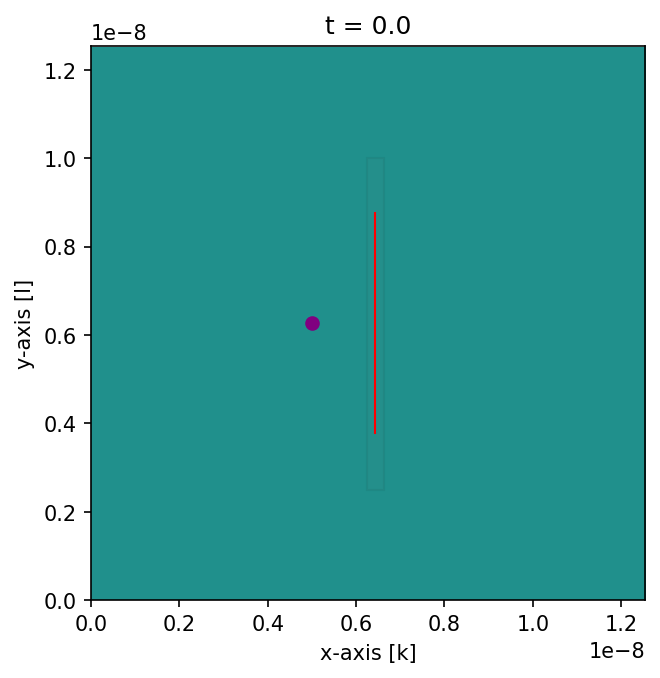

In [5]:

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
anim = test.animate_field()
from IPython.display import HTML
HTML(anim.to_jshtml())




In [6]:
def fourier(Hz, w_max, ZP, rate):
        fourier_transform = np.fft.fft(Hz, n=ZP)*rate
        freq_axis = np.fft.fftfreq(ZP, rate)
        index = np.where(((freq_axis >= 0) & (freq_axis <= w_max/(2*np.pi))))
        freq_axis = freq_axis[index]
        fourier_transform = fourier_transform[index]
        return freq_axis, fourier_transform

def validation(recorder, source, dx, dy, dt):
    x = recorder.x
    y = recorder.y
    sigma = source.sigma
    plt.plot(recorder.data_time, recorder.data)
    plt.show()
    plt.close()
    
    omega_max = 3/sigma
    Hz = np.array(recorder.data)/mu0
    padding = 100000
    freq_axis, FT = fourier(Hz, omega_max, padding, dt)
    omega = freq_axis*2*np.pi
    #bb = source_1.w_max
    # omega = 2*np.pi*ft.rfftfreq(10000, self.dt)  # Get the frequency
    # Hz_freq = ft.rfft(Hz, 10000)
    # width = next((i for i, val in enumerate(omega) if val > omega_max), len(omega))  # Find index where omega > omega_max
    # omega = omega[:width] 
    # Hz_freq = Hz_freq[:width]
    spectralcontent = source.J0*np.sqrt(2*np.pi)*sigma*np.exp(-sigma**2*omega**2/2)
    k0 = omega/ct.c
    z = k0*np.sqrt((x - source.x)**2 + (y - source.y)**2)
    Hz_ana = -dx*dy*source.J0*omega*eps0/4 * hankel2(0, z)
    #print( Hz_ana[1000]/FT/spectralcontent
    plt.plot(omega, np.abs(FT/(spectralcontent)*source.J0))
    plt.plot(omega, np.abs(Hz_ana))
    plt.title("Validation magnetic field at location (" + "{:.6g}".format(x) + "m, " + "{:.6g}".format(y) + "m)")
    plt.xlabel("frequency $\omega$ [Hz]")
    plt.ylabel("$H_{z}$ [A/m]")
    plt.legend(["measured", "theoretical"])
    
    plt.show()
    plt.close()


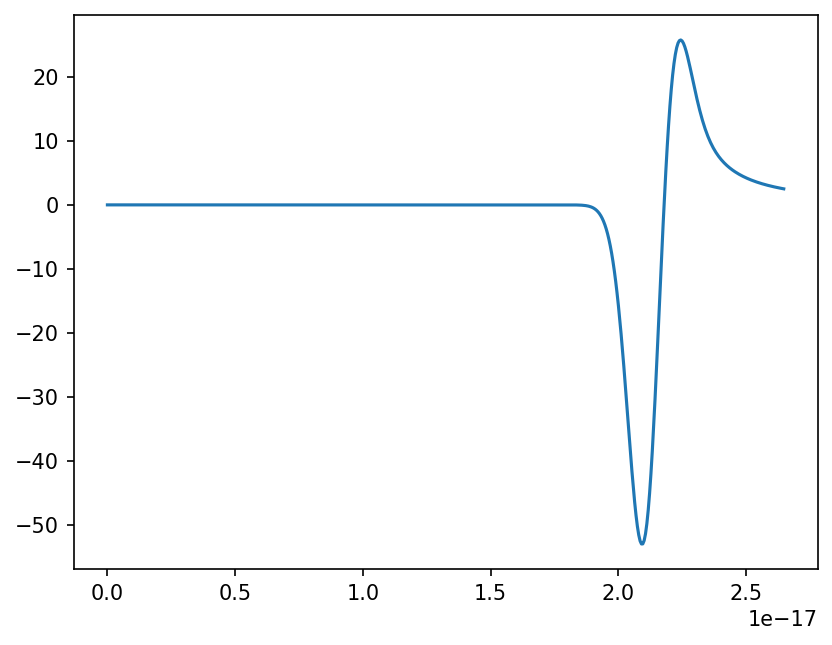

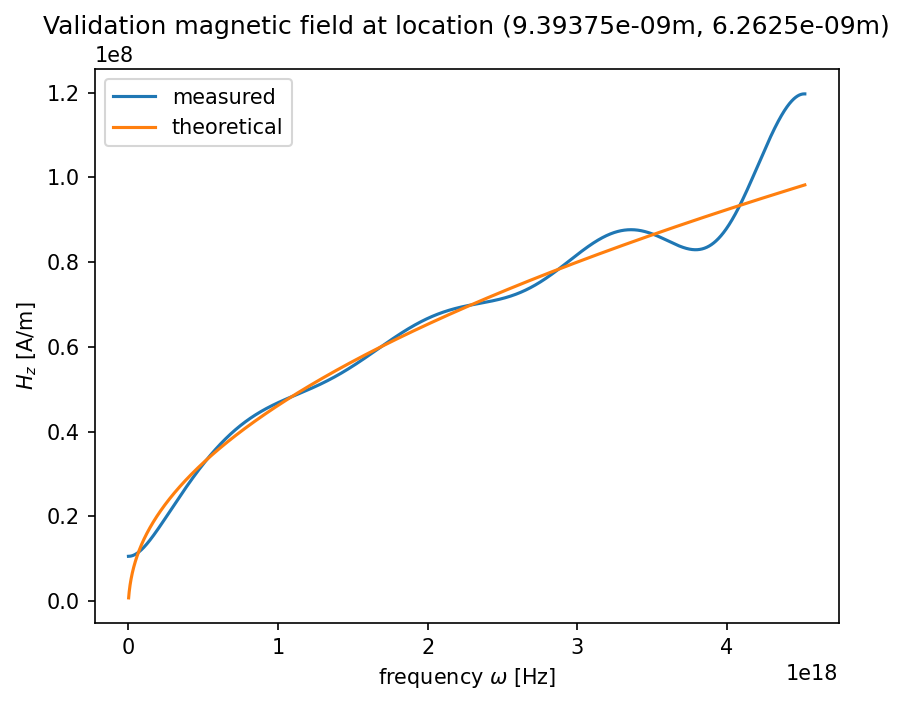

In [7]:
validation(recorder1, source, dx, dy, dt)
